In [1]:
# -*- coding: utf-8 -*-
"""
Generation of Automatic Neuron Graph-Like Interconnected Arrangements (GANGLIA)

Ashlee S. Liao, Yongjie Jessica Zhang, Victoria A. Webster-Wood
GANGLIA: A tool for designing customized neuron circuit patterns
Submitted to: Living Machines 2023

2023 March 31

@author: Ashlee S. Liao
"""
import matplotlib.pyplot as plt
import igraph as ig
import numpy as np
import math
import random
import ezdxf
from ezdxf.addons.drawing.properties import LayoutProperties
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
import cadquery as cq
# import subprocess
import collections
import cairosvg
import matplotlib.image as mpimg
import time

#to check intersections (https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/)

##############
# A Python3 program to find if 2 given line segments intersect or not
  
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
  
# Given three collinear points p, q, r, the function checks if 
# point q lies on line segment 'pr' 
def onSegment(p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and 
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False
  
def orientation(p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
      
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/ 
    # for details of below formula. 
      
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):
          
        # Clockwise orientation
        return 1
    elif (val < 0):
          
        # Counterclockwise orientation
        return 2
    else:
          
        # Collinear orientation
        return 0
  
# The main function that returns true if 
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(p1,q1,p2,q2):
      
    # Find the 4 orientations required for 
    # the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
  
    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
  
    # Special Cases
  
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return True
  
    # If none of the cases
    return False

##################

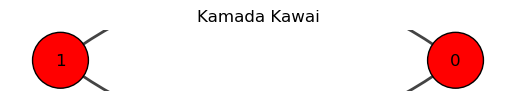

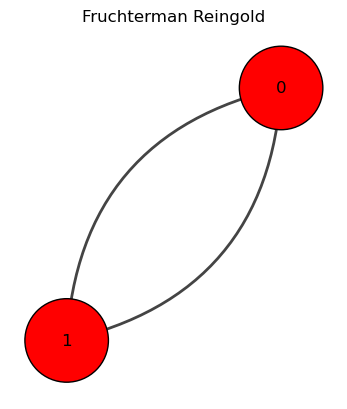

Please select the graph drawing algorithm you wish to continue with.
Kamada-Kawai was selected.
Total number of intersections: 0
Time Elapsed for Procedure 1 (s): 0.17604994773864746
Time Elapsed for Procedure 2 (s): 0.4419844150543213
Time Elapsed Total (s): 0.6180343627929688
IGRAPH U--- 2 2 --
+ attr: isCell (v)
+ edges:
0--1 0--1


In [2]:
##### Setting Up the Tool

#PROCEDURE 1: Determine candidate soma and branching node locations based on connectivity
timeStart = time.time() #start time counter
random.seed(0) #set the random seed to a constant seed for repeatability

######
'''
USER SHOULD COMMENT IN THE APPROPRIATE NETWORK THEY WISH TO GENERATE A PATTERN FOR.
IF THE USER WANTS TO MAKE THEIR OWN CONNECTIVITY LIST, THEY CAN DO IT IN A SIMILAR 
FORMAT AS 'edgeList' OR ('neuronNames' and 'cons') IN THESE EXAMPLES.

The 'edgeList' is the list of connections, as pairs. MUST be only integers.
The 'neuronNames' is a string list of words corresponding to names.
The 'cons' is like 'edgeList', but uses the 'neuronNames' as the pairs, rather than integers.
    'cons' will be converted to 'edgeList', since iGraph requires an input of a list of paired integers.
'''

'''
# Half-Center Oscillator

For more information: 
Marder, E., Bucher, D.: Central pattern generators and the con-
trol of rhythmic movements. Current Biology 11(23), R986–
R996 (11 2001). https://doi.org/10.1016/S0960-9822(01)00581-4
'''

edgeList=[[0,1],
          [1,0]]
#         [2,1]]
saveFileName = "half_center"

######

###### 
'''
Rat Hindlimb Motor Circuit
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6477610/

Deng, K., Szczecinski, N.S., Arnold, D., Andrada, E., Fischer, M.S., Quinn,
R.D., Hunt, A.J.: Neuromechanical Model of Rat Hindlimb Walking with
Two-Layer CPGs. Biomimetics (Basel, Switzerland) 4(1), 21 (3 2019).
https://doi.org/10.3390/biomimetics4010021
'''

# neuronNames = ["ExtensorIN",
#                 "FlexorIN",
#                 "ExtensorHC",
#                 "FlexorHC",
#                 "ExtensorIaIN",
#                 "FlexorIaIN",
#                 "ExtensorMN",
#                 "FlexorMN",
#                 "ExtensorRE",
#                 "FlexorRE"]


# con =  [["ExtensorIN","FlexorHC"], #B64 -> CBI2
#         ["ExtensorHC","ExtensorIN"],   #B4/B5 -> CBI3
#         ["FlexorIN","ExtensorHC"], #CBI2 -> B30/B40
#         ["FlexorHC","FlexorIN"], #CBI4 -> B30/B40
#         ["ExtensorHC","ExtensorIaIN"],  #B64 -> B4/B5
#         ["ExtensorHC","ExtensorMN"], #B31/B32 -> B30/B40
#         ["FlexorHC","FlexorIaIN"],   #B64 -> B30/B40
#         ["FlexorHC","FlexorMN"],   #B31/B32 -> B54
#         ["ExtensorIaIN","FlexorIaIN"],  #B31/32 -> B20
#         ["FlexorIaIN","ExtensorIaIN"],     #B64 -> B20
#         ["ExtensorIaIN","FlexorMN"],      #CBI3 -> B20
#         ["ExtensorRE","ExtensorIaIN"],      #CBI2 -> B20
#         ["FlexorIaIN","ExtensorMN"],      #CBI4 -> B20
#         ["FlexorRE","FlexorIaIN"],       #CBI3 -> B7
#         ["ExtensorMN","ExtensorRE"],    #B64 -> B6/B9 and B3
#         ["ExtensorRE","ExtensorMN"],     #B20 -> B8a/b
#         ["FlexorMN","FlexorRE"],    #B4/B5 -> B6/B9 and B3
#         ["FlexorRE","FlexorMN"],    #B30/B40 -> B8
#         ["FlexorRE","ExtensorRE"],      #B4/B5 -> B8
#         ["ExtensorRE","FlexorRE"]    #B31/B32 -> B8
#         ]

# edgeList = []
# for cons in range(len(con)):
#     pre = neuronNames.index(con[cons][0])
#     post = neuronNames.index(con[cons][1])
#     edgeList.append([pre,post])

# saveFileName = "ratMotor"

#######

#######
# User-designed 9-cell network

# edgeList=[[0,1],
#         [2,0],
#         [3,0],
#         [4,0],
#         [5,0],
#         [6,0],
#         [1,2],
#         [3,2],
#         [7,4],
#         [3,8]]

# saveFileName = "nineCell"

#######

#######

'''
BASED ON WEBSTER-WOOD (2020) CONTROL FOR MULTIFUNCTIONALITY - FIG. 9

Webster-Wood, V.A., Gill, J.P., Thomas, P.J., Chiel, H.J.: Control for multifunc-
tionality: bioinspired control based on feeding in Aplysia californica. Biological Cy-
bernetics 114(6), 557–588 (12 2020). https://doi.org/10.1007/s00422-020-00851-9
'''

# neuronNames = ["CBI-2",
#                 "CBI-4",
#                 "CBI-3",
#                 "B4/B5",
#                 "B30/B40",
#                 "B64",
#                 "B20",
#                 "B7",
#                 "B3/B6/B9",
#                 "B8a/b",
#                 "B31/B32",
#                 "B38"]


# con =  [["B64","CBI-2"], #B64 -> CBI2
#         ["B4/B5","CBI-3"],   #B4/B5 -> CBI3
#         ["CBI-2","B30/B40"], #CBI2 -> B30/B40
#         ["CBI-4","B30/B40"], #CBI4 -> B30/B40
#         ["B64","B4/B5"],  #B64 -> B4/B5
#         ["B31/B32","B30/B40"], #B31/B32 -> B30/B40
#         ["B64","B30/B40"],   #B64 -> B30/B40
#         ["B31/B32","B64"],   #B31/B32 -> B54
#         ["B31/B32", "B20"],  #B31/32 -> B20
#         ["B64","B20"],     #B64 -> B20
#         ["CBI-3","B20"],      #CBI3 -> B20
#         ["CBI-2","B20"],      #CBI2 -> B20
#         ["CBI-4","B20"],      #CBI4 -> B20
#         ["CBI-3","B7"],       #CBI3 -> B7
#         ["B64","B3/B6/B9"],    #B64 -> B6/B9 and B3
#         ["B20", "B8a/b"],     #B20 -> B8a/b
#         ["B4/B5","B3/B6/B9"],    #B4/B5 -> B6/B9 and B3
#         ["B30/B40","B8a/b"],    #B30/B40 -> B8
#         ["B4/B5","B8a/b"],      #B4/B5 -> B8
#         ["B31/B32","B8a/b"],    #B31/B32 -> B8
#         ["B64","B31/B32"],   #B64 -> B31/B32
#         ["CBI-3","B38"]       #CBI3 -> B38
#         ]

# edgeList = []
# for cons in range(len(con)):
#     pre = neuronNames.index(con[cons][0])
#     post = neuronNames.index(con[cons][1])
#     edgeList.append([pre,post])

# saveFileName = "boolean"

################


allPreCells = [preC[0] for preC in edgeList] #all the pre-synaptic cells in the list
preCellCounter = collections.Counter(allPreCells) #count how many repeats of the same pre-synaptic cell (multiple axonal outputs)
multiAxonPre = {k:v for (k,v) in preCellCounter.items() if v > 1} #list of all the pre-synaptic cells with multiple axonal outputs
multiAxonPreCellID = list(multiAxonPre) #list version

#initial cell ID value for the first branching node or "false cell"
#this value is the next largest cell ID number
fcVal = max([element for innerList in edgeList for element in innerList])+1
falseCells = [] #preallocate an empty array to record all the false cells or branching nodes

#add additional connection pairs based on branching nodes needed
for fcInsert in range(len(multiAxonPreCellID)):
    falseCells.append(fcVal)
    multiAxonCellTemp = multiAxonPreCellID[fcInsert]
    idxMultiAxon = [i for i, x in enumerate(allPreCells) if x == multiAxonCellTemp]
    for fc in range(len(idxMultiAxon)):
        edgeList[idxMultiAxon[fc]][0] = fcVal
        
    edgeList.append([multiAxonCellTemp,fcVal])
    fcVal = fcVal + 1

numCells = np.max(edgeList)+1 #number of cells & branching nodes
numEdges = len(edgeList) #number of connections or edges


#Create an iGraph Graph based on the connections list
g = ig.Graph(edges=edgeList)

#add an attribute to the graph based on whether the cell ID is for a real cell ('True') or a branching node ('False')
g.vs["isCell"] = True
for i in range(len(falseCells)):
    g.vs[falseCells[i]]["isCell"] = False

#generate the somas/branching node placements based on either the Kamada-Kawai ('kk') or Fruchterman-Reingold ('fr') algorithms
    #Kamada-Kawai
fig_kk,ax_kk = plt.subplots()
ax_kk.set_aspect("equal")
l_kk = g.layout_kamada_kawai()
ig.plot(g,layout=l_kk,target=ax_kk,axes=False,vertex_label=g.vs.indices)
lcoord_kk = l_kk.coords
plt.title('Kamada Kawai')
plt.show()

    #Fruchterman-Reingold
fig_fr,ax_fr = plt.subplots()
ax_fr.set_aspect("equal")
l_fr=g.layout_fruchterman_reingold()
ig.plot(g,layout=l_fr,target=ax_fr,axes=True,vertex_label=g.vs.indices)
lcoord_fr = l_fr.coords
plt.title('Fruchterman Reingold')
plt.show()

time_graphPreUser = time.time() #end timer for Procedure 1
time_procedure1 = time_graphPreUser - timeStart #duration for Procedure 1

#USER INPUT
#Here is where the user is prompted to select which set of soma/branching node placements
#that the user wishes to use for the pattern generation
print("Please select the graph drawing algorithm you wish to continue with.")
graphDrawingUserChoice = input("For Kamada-Kawai, enter 'kk'. For Fruchterman-Reingold, enter 'fr': ")
whileLoopSignal = 0

while whileLoopSignal == 0:
    if graphDrawingUserChoice == "kk":
        whileLoopSignal = 1
        print("Kamada-Kawai was selected.")
        
        lcoord = lcoord_kk
        
    elif graphDrawingUserChoice == "fr":
        whileLoopSignal = 2
        print("Fruchterman-Reingold was selected.")
        
        lcoord = lcoord_fr
        
    else:
        print("Your input was invalid. Please select an appropriate option.")
        print("Please select the graph drawing algorithm you wish to continue with.")
        graphDrawingUserChoice = input("For Kamada-Kawai, enter 'kk'. For Fruchterman-Reingold, enter 'fr': ")
        
    
saveFileName = saveFileName + "_" + graphDrawingUserChoice #update the save file name to include with kk or fr
time_graphPostUser = time.time() #begin timer for Procedure 2

#   BEGIN PROCEDURE 2: Generate neural circuit micro-pattern
#### Get Distances between somas and/or branching nodes
dist_mat =np.zeros(numEdges)
for i in range(numEdges):
    dist_mat[i] = abs(math.dist(lcoord[edgeList[i][0]],lcoord[edgeList[i][1]]))

#Feature sizes for the pattern (can be edited by the User)
somaR = 25; #soma radius, um
neuriteWidth = 10; #neurite short dimension, um
axonLength = 90; #axon long dimension, um (target/average length desired)
dendriteLength = 20; #dendrite long dimension, um
gapLength = 10; #distance between the end of the axon and the end of the dendrite (synaptic cleft)

extrudeThickness = 5 #extrude thickness for the 3D model

#the following are parameters only if the soma area space needs a scoop (not necessary for now)
scoopDepth = 2.5 #how deep into the extrude should the deepest point of the scoop should go (center of a sphere)
                 #ideally, this value should be less than the extrude thickness
scoopR = 15 #the radius of the scoop at the top rim
            #ideally, this value should be less than the somaR
scoopSphereR = scoopDepth/2 + (scoopR*2)**2/(8*scoopDepth) #radius of the sphere to make the desired scoop

multiBump = 50 #if there is a mutually connected pair with no additional axonal outputs, this is the sagitta of the arc pathway between the two cells

avgDist = np.mean([min(dist_mat), max(dist_mat)]) #average distance between all of the somas and/or branching nodes
scaleFactor = (axonLength+dendriteLength+2*somaR+gapLength)/avgDist #scale factor for soma/branching node position

#scaling the model
scaledCoords = np.array(lcoord)*scaleFactor
scaledDist = dist_mat*scaleFactor
#scaledCoords = scaledCoords - scaledCoords[0,:] #uncomment if you want the coordinates to also be normalized, relative to the first cell
                                                 #uncommenting may cause issues due to the first cell having coordinates of (0,0)
#scaledCoordsMM = scaledCoords/1000 #only for reporting purposes if someone wanted to scale the coordinates value by 1000


angs = [None]*numCells #preallocate an array for storing angles for neurite orientation, relative to the global coordinate system
neuritesCount = np.zeros(numCells) #preallocate array for counting the number of neurites per cell

minNeurites = 4  #minimum number of neurites per cell (to ensure polarity if the pattern were to be used for microcontact printing)
'''
Based on:
Yamamoto, H., Matsumura, R., Takaoki, H., Katsurabayashi, S., Hirano-
Iwata, A., Niwano, M.: Unidirectional signal propagation in primary
neurons micropatterned at a single-cell resolution. Applied Physics
Letters 109(4), 043703 (7 2016). https://doi.org/10.1063/1.4959836

They patterned neurons to grow on bipolar, quadrupolar, and octupolar patterns.
They found that the quadrupolar pattern worked well in terms of the health of the 
cells and their ability to appropriately polarize.

***********************************************
***Currently the method to add additional neurites to meet the minimum expects the minimum neurites to be added
to be 4 - if this value is changed, the tool may not work as intended. **********
'''

numIntersections = 0 #initialize variable for the number of intersections for the whole pattern
multiCellComplete = [] #preallocate an empty array for keeping track of which individual mutual synapsing pairs have already been completed (excluding those with additional axonal outputs)

result = cq.Workplane("XY") #initialize the 3D model

for connection in range(numEdges): #for each connection pair
    #positions of the pre- and post-synaptic connections for testing intersections (first pair of connections)
    pos1_preCell = Point(scaledCoords[edgeList[connection][0]][0], scaledCoords[edgeList[connection][0]][1])
    pos1_postCell = Point(scaledCoords[edgeList[connection][1]][0], scaledCoords[edgeList[connection][1]][1])
    
    #determine whether there are any intersections in the pattern
    for jj in range(numEdges - connection - 1):
        # print("Comparing: " + str(edgeList[connection]) + " and " + str(edgeList[connection+jj+1]) )
        #positions of the pre- and post-synaptic connections for the second pair of connections
        pos2_preCell = Point(scaledCoords[edgeList[connection+jj+1][0]][0], scaledCoords[edgeList[connection+jj+1][0]][1])
        pos2_postCell = Point(scaledCoords[edgeList[connection+jj+1][1]][0], scaledCoords[edgeList[connection+jj+1][1]][1])
        if doIntersect(pos1_preCell, pos1_postCell, pos2_preCell, pos2_postCell) and (not bool(set(edgeList[connection]) & set(edgeList[connection+jj+1]))):
            numIntersections = numIntersections + 1
            print(str(edgeList[connection]) + " and " + str(edgeList[connection+jj+1]) + " intersect.")
    
    #coordinates of the pre- and post-synaptic connections
    preSynCoord = scaledCoords[edgeList[connection][0]]
    postSynCoord = scaledCoords[edgeList[connection][1]]
    
    #increase number count of neurites for each cell in the connection
    neuritesCount[edgeList[connection][0]] = neuritesCount[edgeList[connection][0]]+1
    neuritesCount[edgeList[connection][1]] = neuritesCount[edgeList[connection][1]]+1
    
    #angle in which the pre-synaptic cell is relative to the post-synaptic cell
    post2preAng = math.degrees(math.atan2( (preSynCoord[1]-postSynCoord[1]), (preSynCoord[0]-postSynCoord[0])) )
    
    #re-set the angle from [-180, 180] to [0, 360]
    if post2preAng < 0:
        post2preAng = post2preAng + 360
        pre2postAng = post2preAng - 180

    else:
        pre2postAng = post2preAng + 180
        
    
    
    if g.count_multiple(connection) == 2: #if the two connecting points are mutually synapsing, add 2 curved neurite paths
        
        #curved path for the dendrite and axon (no gap yet) (sagitta arc)
        dendriteAxon = cq.Workplane("XZ",origin=(postSynCoord[0],postSynCoord[1],extrudeThickness/2)).rect(neuriteWidth,extrudeThickness).sweep(cq.Workplane("XY",origin=(postSynCoord[0],postSynCoord[1],0)).sagittaArc((preSynCoord[0]-postSynCoord[0],preSynCoord[1]-postSynCoord[1]),multiBump))
        
        result = result.union(dendriteAxon)
        multiCellComplete.append(edgeList[connection])
        
        #the following is to create the gap between the axon and the dendrite paths
        arcW = math.dist(preSynCoord,postSynCoord) #arc width of sagitta arc
        arcR = multiBump/2 + (arcW**2)/(8*multiBump) #arc radius of sagitta arc
        arcAng = math.degrees(math.acos(1- (multiBump / arcR))) #tangent angle at the start of the sagitta arc
        post2preAng = post2preAng + arcAng
        pre2postAng = pre2postAng - arcAng
        
        #create the gap solid to "cut" from the dendrite/axon path
        gapAngStart = (dendriteLength+(arcR*2*math.asin(somaR/(2*arcR))))/arcR #radians, start angle of gap
        gapChordAng = post2preAng-math.degrees(gapAngStart)/2 #angle of chord for the gap, relative to X axis
        
        chordDist = 2*arcR*math.sin(gapAngStart/2) #chord distance from center of soma to gap
        
        gap_deltaX = chordDist*math.cos(math.radians(gapChordAng)) #change in X coordinate, relative to soma center, to reach gap beginning
        gap_deltaY = chordDist*math.sin(math.radians(gapChordAng)) #change in Y coordinate, relative to soma center, to reach gap beginning
        
        gapEndAng = (dendriteLength+(arcR*2*math.asin(somaR/(2*arcR))) + gapLength)/arcR #radians, end point of gap
        gapEndChordAng = post2preAng-math.degrees(gapEndAng)/2 #angle of chord, relative to X axis
        chordDistEnd = 2*arcR*math.sin(gapEndAng/2) #chord distance from center of soma to end of gap
        gapEnd_deltaX = chordDistEnd*math.cos(math.radians(gapEndChordAng)) #change in X coordinate, relative to soma center, to reach gap beginning
        gapEnd_deltaY = chordDistEnd*math.sin(math.radians(gapEndChordAng)) #change in Y coordinate, relative to soma center, to reach gap beginning
        
        #intial solid from the cell to the start of the gap
        gap5 = cq.Workplane("XZ",origin=(postSynCoord[0],postSynCoord[1],3*extrudeThickness/4)).rect(neuriteWidth*1.1,extrudeThickness/2).sweep(cq.Workplane("XY",origin=(postSynCoord[0],postSynCoord[1],0)).radiusArc((gap_deltaX, gap_deltaY),arcR))
        #initial solid from the cell to the end of the gap
        gap6 = cq.Workplane("XZ",origin=(postSynCoord[0],postSynCoord[1],3*extrudeThickness/4)).rect(neuriteWidth*1.1,extrudeThickness/2).sweep(cq.Workplane("XY",origin=(postSynCoord[0],postSynCoord[1],0)).radiusArc((gapEnd_deltaX, gapEnd_deltaY),arcR))
        
        #cut the gap5 solid from the gap6 solid to create the solid for the gap
        gap7 = gap6.cut(gap5)
        
        #cut the gap7 from the dendriteAxon path to separate them and create the synaptic cleft
        result = result.cut(gap7)


    else: #if not a mutually synapsing connection add straight paths for the dendrite and axon
        
        #create a short path solid for the dendrite based on the dendrite length from the post-synaptic cell, towards the pre-synaptic cell
        dendrite = cq.Workplane("XY").rect(dendriteLength+somaR,neuriteWidth,centered=False).extrude(extrudeThickness).translate((0,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),post2preAng).translate((postSynCoord[0],postSynCoord[1],0))
        result = result.union(dendrite) #add the dendrite solid to the full model
        
        #calculate the axonal length based on the dendrite length, gap length, and the remaining distance between the pre- and post-synaptic cells
        axonLen = scaledDist[connection]-somaR-gapLength-dendriteLength

        #create a long path solid for the axon based on the axon length, from the pre-synaptic cell, towards the post-synaptic cell
        axon = cq.Workplane("XY").rect(axonLen,neuriteWidth,centered=False).extrude(extrudeThickness).translate((0,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),pre2postAng).translate((preSynCoord[0],preSynCoord[1],0))
        result = result.union(axon) #add the axon solid to the full model
        
        #do not add the gap if the connection is with a branching node (fill the gap space). else, add a gap (do not fill the gap space)
        if edgeList[connection][1] in set(falseCells):
            gap = cq.Workplane("XY").rect(gapLength,neuriteWidth,centered=False).extrude(extrudeThickness).translate((axonLen,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),pre2postAng).translate((preSynCoord[0],preSynCoord[1],0))
        else:
            gap = cq.Workplane("XY").rect(gapLength,neuriteWidth,centered=False).extrude(extrudeThickness/2).translate((axonLen,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),pre2postAng).translate((preSynCoord[0],preSynCoord[1],0))
        
        result = result.add(gap) #add the relevant gap solid to the full model
        
    #record all of the angles for the pre- and post-synaptic cells
    if angs[edgeList[connection][1]] is None:
        angs[edgeList[connection][1]] = [post2preAng]
    else:
        angs[edgeList[connection][1]].append(post2preAng)
    
    if angs[edgeList[connection][0]] is None:
        angs[edgeList[connection][0]] = [pre2postAng]
    else:
        angs[edgeList[connection][0]].append(pre2postAng)
        
print("Total number of intersections: " + str(numIntersections))        
        
        
#This for loop adds additional neurites, if the minimum is not met, and the solids for the somas (for each cell)
for i in range(numCells):
    
    #check if the cell has already has an axon
    hasAxon = any(cIdx in [i] for cIdx in allPreCells)
    
    #check if the cell is a branching node or already met the neurite minimum. If so, do not add more neurites and do not add a large circular area for a soma.
    if any(cIdx in [i] for cIdx in falseCells):
        print("The cell " + str(i) + " is a false cell. No soma or extra dendrites will be added.")
        falseSoma = cq.Workplane("XY").box(neuriteWidth,neuriteWidth,extrudeThickness).translate((scaledCoords[i][0],scaledCoords[i][1],extrudeThickness/2))
        result = result.union(falseSoma)

    elif (angs[i] == None):
        print("The cell " + str(i) + " has no connections. No soma or extra dendrites will be added.")
        
    else: #cell is a real cell (not branching node) and has less than the minimum number of neurites
        
        #calculate the largest angular gap between the existing neurites
        angsSort = sorted(angs[i])
        angsDiff = np.append(np.diff(angsSort),(angsSort[0]+360-angsSort[-1]))
        largestGap = max(angsDiff)
        largestGapLoc = np.argmax(angsDiff)
        
        #calculate the number of neurites to be added to meet the minimum
        numDen2Add = int(minNeurites - neuritesCount[i])
            
        #The method to determine the angular orientation of the remaining neurites
        #depends on the angular gaps between the existing neurites and the number of 
        #remaining neurites to be added.
            
        if numDen2Add == 2: #if the number of neurites to be added is 2
            #deterine which method to add the remaining neurites based on the standard 
            # deviation of the neurite angle orientation
            #the method that results in the smallest standard deviation is the method used
            #for placing additional neurites
            
            #method 1 - put both neurites within the largest gap
            method1_midAngDelta = largestGap/3
            method1_std = np.std([min(angsDiff), method1_midAngDelta, method1_midAngDelta, method1_midAngDelta])
            
            
            #method 2 - put one neurite between each gap
            method2_midAngDelta = angsDiff/2            
            method2_std = np.std([method2_midAngDelta[0], method2_midAngDelta[0], method2_midAngDelta[1], method2_midAngDelta[1]])
            denAng = np.ones(2)
            
            if method1_std < method2_std:
                denAng[0] = angsSort[largestGapLoc] + method1_midAngDelta
                denAng[1] = denAng[0] + method1_midAngDelta
            else:
                denAng[0] = angsSort[0] + method2_midAngDelta[0]
                denAng[1] = angsSort[1] + method2_midAngDelta[1]
                
            for denIdx in range(2):
                
                #if the neuron does not already have an axon, add one of the remaining
                #neurites with the target axon length. else, add a dendrite
                if denIdx == 0 and hasAxon == False:
                    neuriteLength = axonLength
                else:   
                    neuriteLength = dendriteLength
                
                neurite = cq.Workplane("XY").rect(neuriteLength+somaR,neuriteWidth,centered=False).extrude(extrudeThickness).translate((0,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),denAng[denIdx]).translate((scaledCoords[i][0],scaledCoords[i][1],0))
                result = result.union(neurite)
                
            
                
        elif numDen2Add == 1: #number of neurites to add is 1
        
            #add the single neurite in the middle of the largest gap between the existing neurites
            addDenAng = angsSort[largestGapLoc] + largestGap/2
            
            #if the neuron does not already have an axon, add one of the remaining
            #neurites with the target axon length. else, add a dendrite
            if hasAxon == False:
                neuriteLength = axonLength
            else:
                neuriteLength = dendriteLength
            
            neurite = cq.Workplane("XY").rect(neuriteLength+somaR,neuriteWidth,centered=False).extrude(extrudeThickness).translate((0,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),addDenAng).translate((scaledCoords[i][0],scaledCoords[i][1],0))
            result = result.union(neurite)
                        
        elif numDen2Add == 3: #number of neurites to add is 3
        
            #With the assumption that the minimum number of neurites to add is 4
            #that means there is only one existing neurite.
            #For four neurites evenly spaced, all of the neurites are 90 degrees relative to each other

            #if the neuron does not already have an axon, add one of the remaining
            #neurites with the target axon length. else, add a dendrite
            for denIdx in range(3):
                if denIdx == 0 and hasAxon == False:
                    neuriteLength = axonLength
                else:   
                    neuriteLength = dendriteLength

                neurite = cq.Workplane("XY").rect(neuriteLength+somaR,neuriteWidth,centered=False).extrude(extrudeThickness).translate((0,-neuriteWidth/2,0)).rotate((0,0,0),(0,0,1),angs[i][0]+(90*(1+denIdx))).translate((scaledCoords[i][0],scaledCoords[i][1],0))
                result = result.union(neurite)
                
        elif numDen2Add <= 0: #number of neurites is less than or equal to 0 - means there are no neurites that need to be added
            print("No dendrites need to be added for cell ID: " + str(i))
            
        else: #if for some reason, an invalid number is needed (likely the minimum neurites was changed to be larger than 4 or not a number)
            print("Invalid number of extra neurites to add")

        soma = cq.Workplane("XY").circle(somaR).extrude(extrudeThickness).translate((scaledCoords[i][0],scaledCoords[i][1],0))
        result = result.union(soma)#.cut(cq.Workplane("XY").sphere(scoopSphereR).translate((scaledCoords[i][0],scaledCoords[i][1],scoopSphereR+extrudeThickness-scoopDepth)))
            #Scoop in the soma area could be uncommented needed
           
time_postModel = time.time() #end timer for procedure 2
timeElapsed = (time_graphPreUser - timeStart) + (time_postModel - time_graphPostUser) #total time elapsed (procedure1 + procedure2) DOES NOT INCLUDE USER SELECTION TIME
time_procedure2 = (time_postModel - time_graphPostUser) #time elapsed for procedure 2

print("Time Elapsed for Procedure 1 (s): " + str(time_procedure1))
print("Time Elapsed for Procedure 2 (s): " + str(time_procedure2))
print("Time Elapsed Total (s): " + str(timeElapsed))
print(g)


In [3]:
display(result)

Results saving...


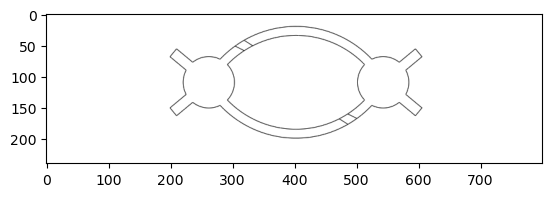

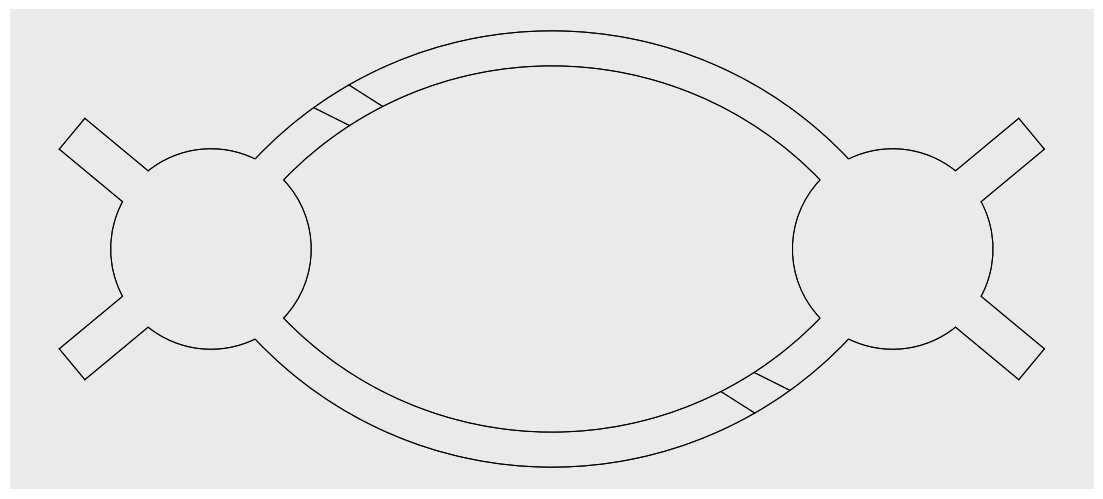

In [5]:
# The user is asked whether they would like to actually save the results.

graphDrawingUserChoice = input("Do you want to save the results? [y/n]: ")
whileLoopSignal = 0

while whileLoopSignal == 0:
    if graphDrawingUserChoice == "y":
        
        print("Results saving...")   
        ''' USER NEEDS TO UPDATE THIS AS NEEDED
            #Directory to export files to 
        '''
        exportDir = input("Save Directory: ") or 'G:/Shared drives/CMU BORG - Constrained Neuron Patterning & Transfer/02 Design Tool/exportTests/v11'
        # exportDir = 'G:/Shared drives/CMU BORG - Constrained Neuron Patterning & Transfer/02 Design Tool/exportTests/v11'
        
        fig_kk.savefig(exportDir+"/intermediate_kk_"+saveFileName+".svg", format="svg", dpi=1200)
        fig_fr.savefig(exportDir+"/intermediate_fr_"+saveFileName+".svg", format="svg", dpi=1200)

        cq.exporters.export(
                            result,
                            exportDir+"/CAD_" + saveFileName +".svg",
                            opt={
                                "showAxes": False,
                                "projectionDir": (-0.25, -0.25, 0.5),
                                }
                            )
        
        cq.exporters.export(
                            result,
                            exportDir + "/" + saveFileName + ".stp",
                            cq.exporters.ExportTypes.STEP)
        
            #SVG Export - XY Plane from above
        bb = result.val().BoundingBox()
        cq.exporters.export(result,
                            (exportDir + "/XYplane_" + saveFileName + '.svg'),
                            opt={
                                "showAxes": False,
                                "projectionDir":(0,0,1),
                                "output_width":bb.xlen,
                                "output_height":bb.ylen})
        
            # visualize the SVG export
        
        fig = plt.figure()
        img_png = cairosvg.svg2png(url=(exportDir + "/XYplane_" + saveFileName + '.svg'),write_to=(exportDir + "/XYplane_" + saveFileName +'.png'))
        img = mpimg.imread((exportDir + "/XYplane_" + saveFileName +'.png'))
        imgplot = plt.imshow(img)
        plt.show()
        
            #DXF Export (looks like XY planeish - have some weird spare lines)
        cq.exporters.export(result,
                            exportDir + "/" + saveFileName + ".dxf")
        doc = ezdxf.readfile(
                            exportDir + "/" + saveFileName + ".dxf")
        msp = doc.modelspace()
        
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ctx = RenderContext(doc)
        msp_properties = LayoutProperties.from_layout(msp)
        msp_properties.set_colors("#eaeaeaff")
        out = MatplotlibBackend(ax)
        Frontend(ctx, out).draw_layout(
            msp,
            finalize=True,
            layout_properties=msp_properties,
            )
        plt.show()
        
        whileLoopSignal = 1

    elif graphDrawingUserChoice == "n":
        
        print("Results not saved.")
        whileLoopSignal = 2
        
    else:
        print("Your input was invalid. Please select an appropriate option.")
        graphDrawingUserChoice = input("Do you want to save the results? [y/n]: ")